In [1]:
import numpy as np

import json

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import sepia

import jak
import matplotlib.pyplot as plt

import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

from IPython.display import clear_output

In [2]:
measurement_dict = {"pIC50": 0 , "pKi": 1}
enzyme_dict = {"JAK1": 0, "JAK2": 1, "JAK3": 2, "TYK2": 3}

def find_values(smile, df):
    
    df_smile = df.loc[df["SMILES"] == smile]
    
    x = []
    y = []
    print(df_smile.head())
    for ii in range(len(df_smile)):
              
        index = measurement_dict[df_smile["measurement_type"].to_list()[ii]] * len(enzyme_dict.keys()) \
                + enzyme_dict[df_smile["Kinase_name"].to_list()[ii]]
      
        x.append(index)
        y.append(df_smile["measurement_value"].to_numpy()[ii])
    
    x = np.array(x)
    y = np.array(y)
    x_pic50 = x[x < 4.] + 1
    y_pic50 = y[x < 4.]
    
    x_pki = x[x >= 4.] - 3
    y_pki = y[x >= 4.]
    
    return (x_pic50, y_pic50, x_pki, y_pki)
    
    

In [3]:
df = pd.read_csv("../data/train_JAK.csv")
unique_smiles = df["SMILES"].unique()

example_indices = np.random.randint(0,len(unique_smiles), size=(16,))
smiles_examples = unique_smiles[example_indices]

In [4]:
# set up feature extractor model (pre-trained autoregressive transformer)

seq_length = 100
token_dim = 33
encoder_size = 1
decoder_size = 1
smiles_vocab = "#()+-1234567=BCFHINOPS[]cilnors"
parameters_fp = "../parameters/xformer_001_1e1d.npy"

xformer = sepia.seq.transformer.Transformer(vocab = smiles_vocab, \
                                          token_dim=token_dim, \
                                          seq_length=seq_length, \
                                          lr=1e-3,  
                                          encoder_size=encoder_size,\
                                          decoder_size=decoder_size)

xformer.parameters = sepia.seq.functional.set_parameters(np.load(parameters_fp), xformer.parameters)

encode = lambda s: torch.tensor(np.array(xformer.encode(s))).reshape(1,-1)

2023-01-21 18:05:49.657908: W external/org_tensorflow/tensorflow/compiler/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 6372196352
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [5]:
# set up regression model ensemble (multiple MLPs)

kwarg_filepath = "../parameters/ensemble_002_seed42/exp_tag_ensemble_002_seed42.json"
parameters_filepath = "../parameters/ensemble_002_seed42/tag_ensemble_002_seed42_epoch999.pt"

with open(kwarg_filepath, "r") as f:
    kwargs = json.load(f)
    
in_dim = 3300
out_dim = 8
    
ensemble = jak.mlp.MLPCohort(in_dim, out_dim,\
                             cohort_size=kwargs["cohort_size"], \
                             depth=kwargs["depth"], \
                             lr=kwargs["lr"])

ensemble.load_state_dict(torch.load(parameters_filepath))
                             

<All keys matched successfully>

example small molecules in SMILES format:

  0    COc1cc(N2CCN(CC(C)O)CC2)ccc1Nc1ncc2ccc(-c3ccccc3N(C)S(C)(=O)=O)n2n1
  1    Cc1[nH]c(C=C2C(=O)Nc3ccccc32)c(C)c1CCC(=O)O
  2    N#CC1CCOCC1n1cc(C(N)=O)c(Nc2ccnc(F)c2)n1
  3    CN1CN(C2CCC(CNC3(C#N)CC3)CC2)c2c(cnc3[nH]ccc23)C1=O
  4    CS(=O)(=O)C1C2CCC(CC2)C1Nc1nc(-c2c[nH]c3ncc(F)cc23)ncc1F
  5    CCC1CN(C(=O)C2(C#N)CC2)CC1Nc1c(C(N)=O)cnn2cc(-c3cnn(C)c3)nc12
  6    CC1CN(c2ccc(C#N)cn2)CC1Nc1c(C(N)=O)cnn2cc(-c3cnn(CC(=O)N4CCC(F)(F)C4)c3)cc12
  7    CN(CCCN1CCC(n2cc(NC(=O)c3c(N)nn4cccnc34)c(-c3cc(Cl)ccc3OC(F)F)n2)CC1)C(=O)c1ccccc1
  8    CN1CCN(C(=O)Cn2cc(NC(=O)c3c(N)nn4cccnc34)c(-c3cc(Cl)ccc3OC(F)F)n2)CC1
  9    O=C(NC1CCC(c2nnn3cnc4[nH]ccc4c23)CC1)OCc1ccccc1
  10    COc1ccccc1CNc1cccn2nc(Nc3ccncc3)nc12
  11    CC(O)C1C2CCC(CC2)C1Nc1nc(-c2c[nH]c3ncc(F)cc23)ncc1F
  12    Cc1ccc(NC(=O)c2cccc(C(F)(F)F)c2)cc1N1CCc2nc(Nc3ccc(C(=O)NC4CC4)nc3)ncc2C1
  13    c1cc2c(ncn3nnc(C4CCC(CNC5CC5)CC4)c23)[nH]1
  14    CN1CC=CCCn2ccc3ccc(cc32)-c2ccnc(n2)Nc2c

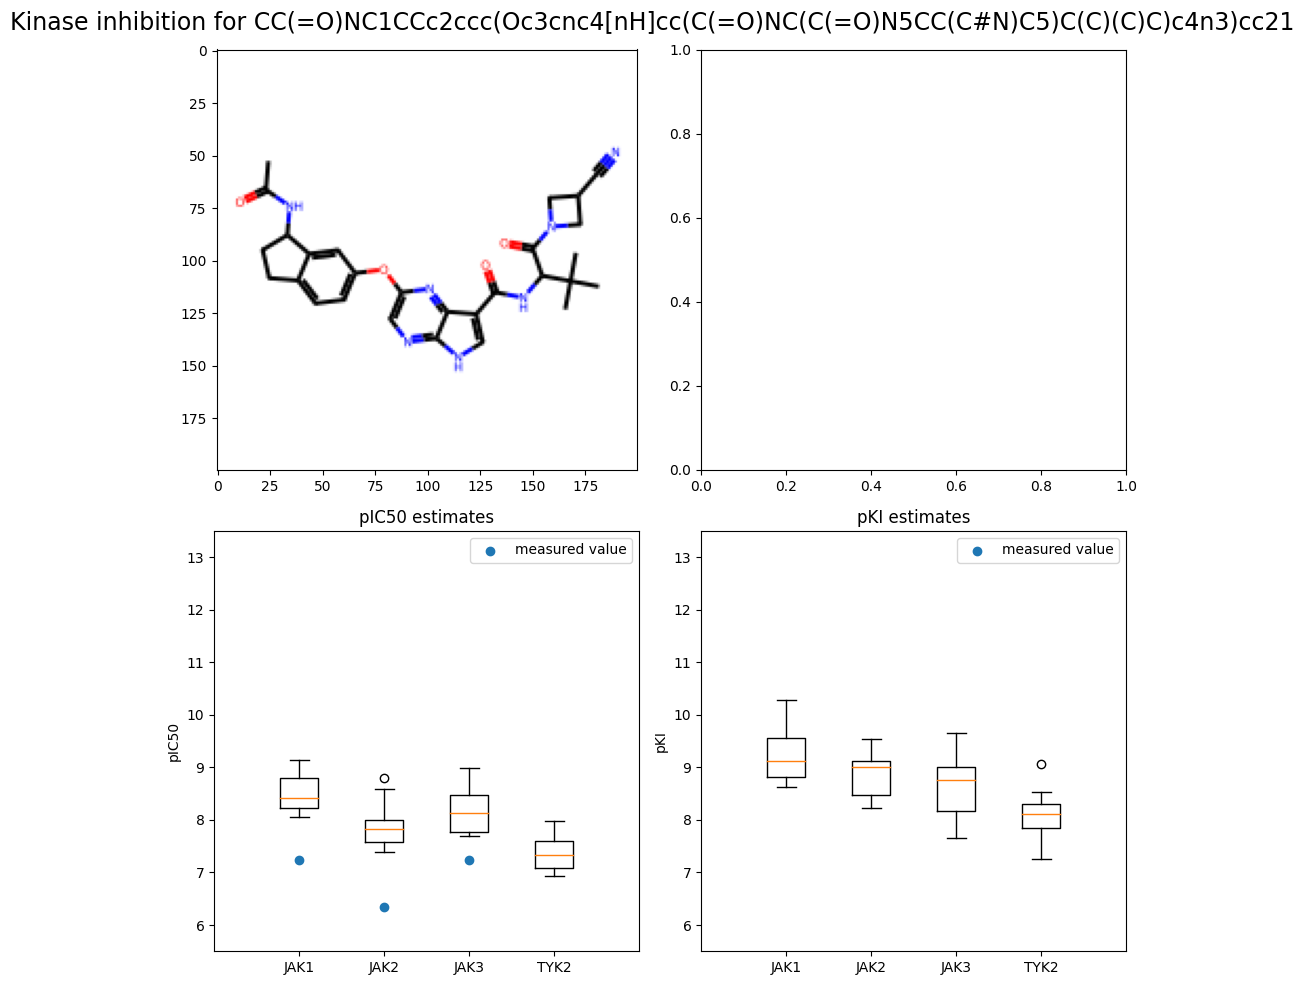

Estimate for another molecule? (y)es/(n)on


In [6]:
do_estimate = True

min_x = 5.5
max_x = 13.5

while do_estimate:

    msg = "example small molecules in SMILES format:\n\n"
    for ii, example in enumerate(smiles_examples):
        msg += f"  {ii}    {example}\n"

    print(msg)
    smile = input("enter a small molecule in SMILES format, or enter the index of an example above")

    if len(smile) < 3:
        smile = smiles_examples[int(smile)]

    print(f"\n SMILE format molecule: {smile}")


    encoded = encode(smile)
    ensemble.eval()
    estimates = ensemble.forward_ensemble(encoded).squeeze()

    # inhibition estimates in order pIC50 JAK1, JAK2, JAK3, TYK2; pKI JAK1, JAK2, JAK3, TYK2
    x = estimates.numpy()
    fig, ax = plt.subplots(2,2, figsize=(10,10))

    ax[1,0].boxplot(x[:,:4])
    ax[1,1].boxplot(x[:,4:])

    ax_ticks = [1,2,3,4]

    ax_ticklabels = ["JAK1", "JAK2", "JAK3", "TYK2"]


    ax[1,0].set_xticklabels(ax_ticklabels)
    ax[1,1].set_xticklabels(ax_ticklabels)

    ax[1,0].set_ylabel("pIC50")
    ax[1,1].set_ylabel("pKI")

    fig.suptitle(f"Kinase inhibition for {smile}", fontsize=17)
    ax[1,0].set_title("pIC50 estimates")
    ax[1,1].set_title("pKI estimates")
    ax[1,0].axis([0,5, min_x, max_x])
    ax[1,1].axis([0,5, min_x, max_x])

    x_pic50, y_pic50, x_pki, y_pki = find_values(smile, df)

    ax[1,0].scatter(x_pic50, y_pic50, label="measured value")
    ax[1,1].scatter(x_pki, y_pki, label="measured value")

    ax[1,0].legend()
    ax[1,1].legend()
    
    mol = Chem.MolFromSmiles(smile)
    mol_image = rdkit.Chem.Draw.MolsToImage([mol])
    ax[0,0].imshow(mol_image)
    
    plt.tight_layout()

    plt.show()
    
    do_estimate_string = input("Estimate for another molecule? (y)es/(n)o")
    
    if "y" in do_estimate_string:
        do_estimate = True
    else:
        do_estimate = False
    clear_output(wait=True)